## Goal: build our first image classifier and see if we can achieve world-class results

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
# batch size (reduce this if you run out of memory!)
bs = 64

[Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/)
[O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) 

In [4]:
help(untar_data)

Help on function untar_data in module fastai.datasets:

untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None, data=True)
    Download `url` if doesn't exist to `fname` and un-tgz to folder `dest`



In [5]:
doc(untar_data)

untar_data [source] untar_data ( url : str , fname : PathOrStr = None , dest : PathOrStr = None , data = True ) 
 
 Download url if doesn't exist to fname and un-tgz to folder dest 
 Show in docs

In [6]:
path = untar_data(URLs.PETS)

In [7]:
print(path)

/floyd/home/fastai/data/oxford-iiit-pet


In [8]:
path.ls()

['annotations', 'images']

In [9]:
path_anno = path/'annotations'

In [10]:
path_anno

PosixPath('/floyd/home/fastai/data/oxford-iiit-pet/annotations')

In [11]:
path_img = path/'images'

In [12]:
doc(get_image_files)

get_image_files [source] get_image_files ( c : Path , check_ext : bool = True ) → FilePathList 
 
 Return list of files in c that are images. check_ext will filter to image_extensions . 
 Show in docs

In [13]:
fnames = get_image_files(path_img, True)

In [14]:
fnames[:5]

[PosixPath('/floyd/home/fastai/data/oxford-iiit-pet/images/chihuahua_120.jpg'),
 PosixPath('/floyd/home/fastai/data/oxford-iiit-pet/images/samoyed_162.jpg'),
 PosixPath('/floyd/home/fastai/data/oxford-iiit-pet/images/keeshond_97.jpg'),
 PosixPath('/floyd/home/fastai/data/oxford-iiit-pet/images/chihuahua_179.jpg'),
 PosixPath('/floyd/home/fastai/data/oxford-iiit-pet/images/Sphynx_9.jpg')]

In [15]:
len(fnames)

7390

In [16]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

In [17]:
doc(ImageDataBunch)

class ImageDataBunch [source] ImageDataBunch ( train_dl : DataLoader , valid_dl : DataLoader , test_dl : Optional [ DataLoader ]= None , device : device = None , tfms : Optional [ Collection [ Callable ]]= None , path : PathOrStr = '.' , collate_fn : Callable = 'data_collate' ) :: DataBunch 
 
 Bind train_dl , valid_dl and test_dl to device . tfms are DL tfms (normalize). path is for models. 
 Show in docs

In [18]:
doc(ImageDataBunch.from_name_re)

from_name_re [source] from_name_re ( path : PathOrStr , fnames : FilePathList , pat : str , valid_pct : int = 0.2 , test : str = None , kwargs ) 
 
 Show in docs

In [19]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs)

In [20]:
data.normalize(imagenet_stats)

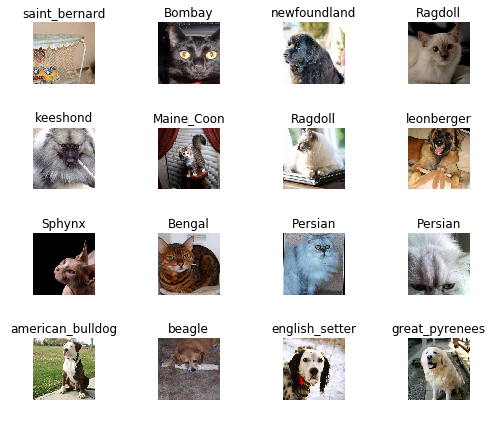

In [21]:
data.show_batch(rows=4, figsize=(7,6))

## Time to train our model

In [22]:
learn = ConvLearner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:40<00:00, 2137604.16it/s]


In [24]:
doc(error_rate)

error_rate [source] error_rate ( input : Tensor , targs : Tensor ) → Rank0Tensor 
 
 1 - accuracy 
 Show in docs

In [25]:
learn.fit_one_cycle(4)

Total time: 05:41
epoch  train_loss  valid_loss  error_rate
1      1.189739    0.334317    0.103792    (01:54)
2      0.506262    0.244845    0.076514    (01:16)
3      0.322667    0.215977    0.072522    (01:15)
4      0.229116    0.214749    0.071856    (01:15)



In [26]:
learn.save('stage-1')

In [27]:
interp = ClassificationInterpretation.from_learner(learn)

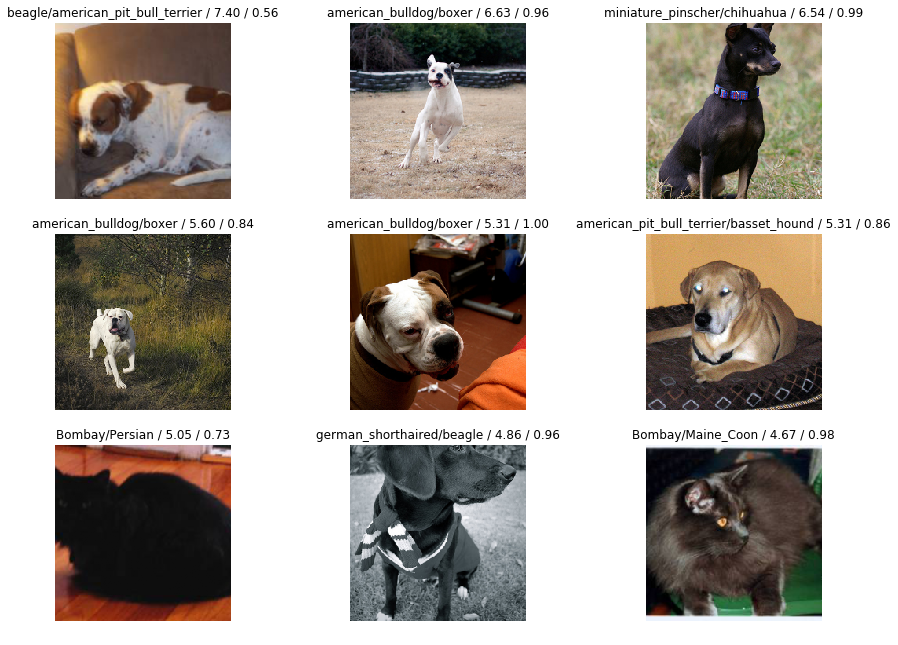

In [28]:
interp.plot_top_losses(9, figsize=(15, 11))

In [29]:
doc(interp.plot_top_losses)

plot_top_losses [source] plot_top_losses ( k , largest = True , figsize = (12, 12) ) 
 
 Show images in top_losses along with their loss, label, and prediction. 
 Show in docs

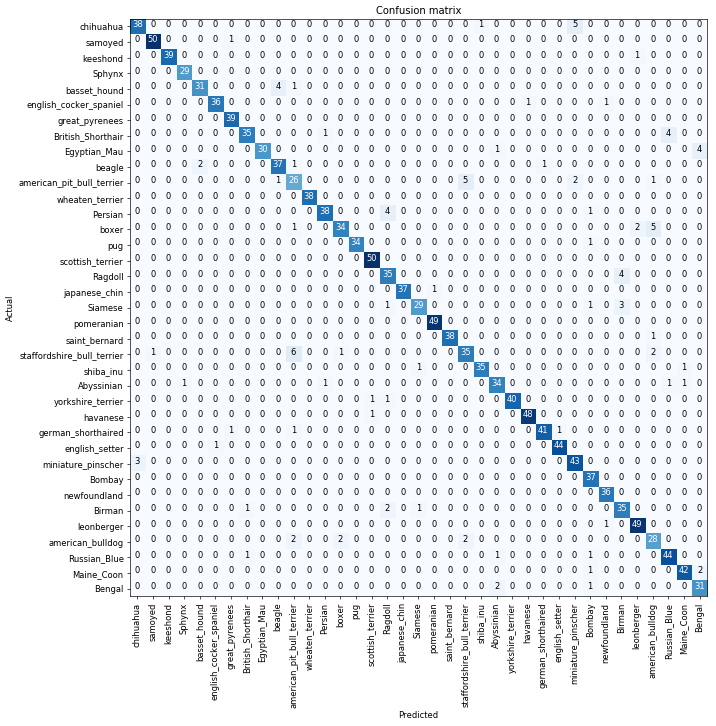

In [30]:
interp.plot_confusion_matrix(figsize=(12, 12), dpi=60)

In [31]:
interp.most_confused(min_val=2)

[('staffordshire_bull_terrier', 'american_pit_bull_terrier', 6),
 ('chihuahua', 'miniature_pinscher', 5),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 5),
 ('boxer', 'american_bulldog', 5),
 ('basset_hound', 'beagle', 4),
 ('British_Shorthair', 'Russian_Blue', 4),
 ('Egyptian_Mau', 'Bengal', 4),
 ('Persian', 'Ragdoll', 4),
 ('Ragdoll', 'Birman', 4),
 ('Siamese', 'Birman', 3),
 ('miniature_pinscher', 'chihuahua', 3)]

In [32]:
doc(learn.unfreeze)

unfreeze [source] unfreeze () 
 
 Unfreeze entire model. 
 Show in docs

In [33]:
learn.unfreeze()

In [35]:
learn.fit_one_cycle(1)

Total time: 01:20
epoch  train_loss  valid_loss  error_rate
1      1.020643    0.553820    0.166999    (01:20)



In [36]:
learn.load('stage-1')

In [37]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


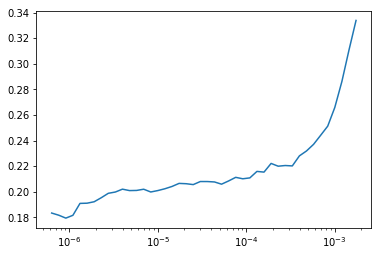

In [38]:
learn.recorder.plot()

In [39]:
learn.unfreeze()

In [40]:
learn.fit_one_cycle(2, max_lr=slice(1e-6, 1e-4))

Total time: 02:39
epoch  train_loss  valid_loss  error_rate
1      0.212920    0.208923    0.070526    (01:20)
2      0.182488    0.200885    0.065203    (01:19)



In [41]:
interp = ClassificationInterpretation.from_learner(learn)

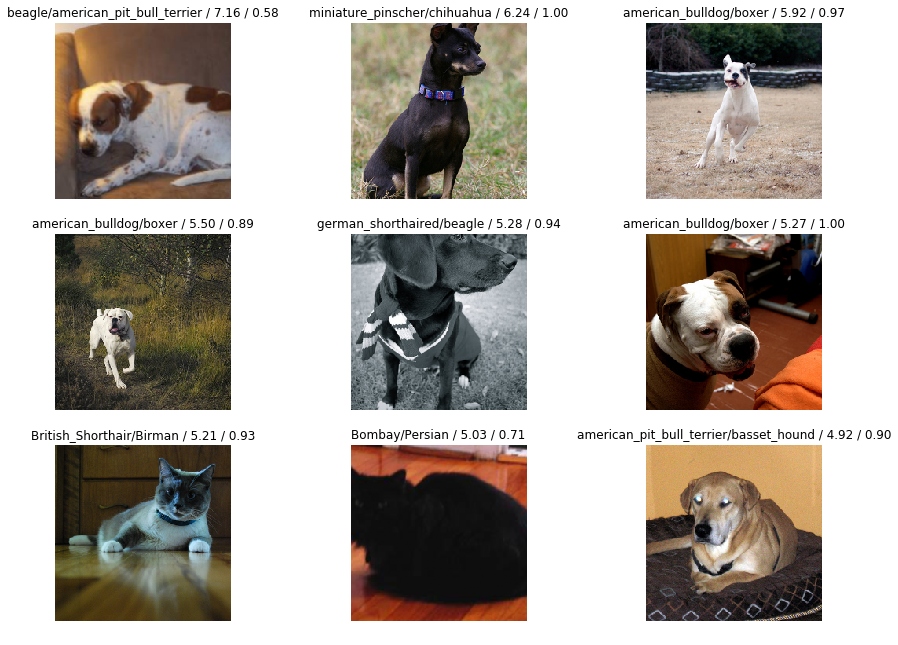

In [42]:
interp.plot_top_losses(9, figsize=(15, 11))

In [43]:
interp.most_confused(min_val=2)

[('chihuahua', 'miniature_pinscher', 5),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 5),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 5),
 ('basset_hound', 'beagle', 4),
 ('boxer', 'american_bulldog', 4),
 ('miniature_pinscher', 'chihuahua', 4),
 ('British_Shorthair', 'Russian_Blue', 3),
 ('Ragdoll', 'Birman', 3),
 ('Siamese', 'Birman', 3)]

### Training with resnet50

In [44]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=320, bs=bs//2)
data.normalize(imagenet_stats)

In [45]:
bs//2

32

In [46]:
bs/2

32.0

In [47]:
learn = ConvLearner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:49<00:00, 2085617.09it/s]


In [48]:
learn.fit_one_cycle(8, max_lr=slice(1e-3))

Total time: 27:55
epoch  train_loss  valid_loss  error_rate
1      0.948864    0.345707    0.093606    (03:58)
2      0.424205    0.214025    0.068556    (03:24)
3      0.301492    0.193795    0.056691    (03:25)
4      0.233200    0.166880    0.057350    (03:25)
5      0.182799    0.158345    0.050099    (03:25)
6      0.138879    0.156368    0.053395    (03:25)
7      0.105651    0.151348    0.047462    (03:25)
8      0.088131    0.147666    0.047462    (03:25)



In [49]:
learn.save('stage-1-50')

NameError: name 'learn' is not defined